In [1]:
!pip install praat-parselmouth

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 63.7 MB/s eta 0:00:00:00:01:01


In [2]:
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt
from glob import glob
import os
import parselmouth
from parselmouth.praat import call
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import librosa

In [3]:
dataset_root = '/kaggle/input/shl-intern-hiring-assessment/Dataset/'
train_df_path = os.path.join(dataset_root, 'train.csv')
test_df_path = os.path.join(dataset_root, 'test.csv')
train_audios_dir = os.path.join(dataset_root, 'audios/train/')
test_audios_dir = os.path.join(dataset_root, 'audios/test/')

print(train_df_path)
print(test_df_path)
print(train_audios_dir)
print(test_audios_dir)
os.listdir(dataset_root)

/kaggle/input/shl-intern-hiring-assessment/Dataset/train.csv
/kaggle/input/shl-intern-hiring-assessment/Dataset/test.csv
/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/train/
/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/test/


['audios', 'sample_submission.csv', 'train.csv', 'test.csv']

In [4]:
train_df = pd.read_csv(os.path.join(train_df_path))
train_df.head()

,filename,label
0,audio_710.wav,1.0
1,audio_1265.wav,1.0
2,audio_1114.wav,1.5
3,audio_946.wav,1.5
4,audio_1127.wav,2.0


# Visualization and Analysis

In [5]:
from IPython.display import Audio
import random

# displaying a random sample from the training dataset
rand_sample = random.randint(1, train_df.shape[0])
print(f'random index: {rand_sample}')
rand_sample_path = train_audios_dir + train_df.iloc[rand_sample]['filename']
print(f'Random Audio Sample: {rand_sample_path}')
Audio(filename=rand_sample_path)

random index: 374
Random Audio Sample: /kaggle/input/shl-intern-hiring-assessment/Dataset/audios/train/audio_147.wav


audio time series: [ 9.4832785e-08 -2.4097928e-05 -2.8071507e-05 ...  1.9096703e-12
  1.9496800e-12  5.3541069e-12]
sampling rate: 22050



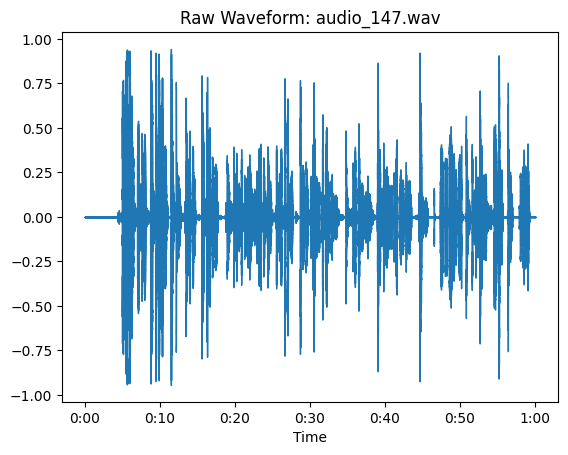

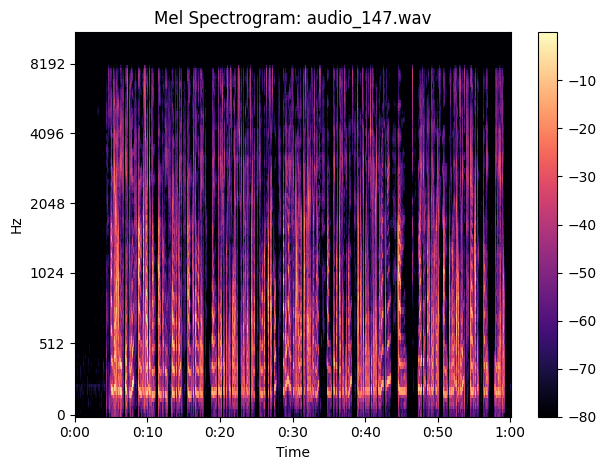

In [6]:
# generating raw waveform and mel spectogram for the random sample
y, sr = librosa.load(rand_sample_path)
print(f'audio time series: {y}')
print(f'sampling rate: {sr}')
print()

librosa.display.waveshow(y=y, sr=sr)
plt.title(f'Raw Waveform: {train_df.iloc[rand_sample]["filename"]}')
plt.show()

# fig, ax = plt.subplots()
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel')
plt.title(f'Mel Spectrogram: {train_df.iloc[rand_sample]["filename"]}')
plt.colorbar()
plt.tight_layout()
plt.show()

Shape of MFCC: (20, 2588)


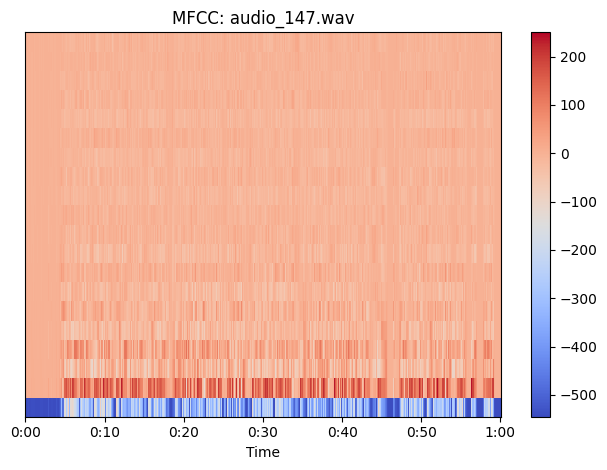

In [7]:
mfcc = librosa.feature.mfcc(y=y, sr=sr)
print(f'Shape of MFCC: {mfcc.shape}')

# fig, ax = plt.subplots()
librosa.display.specshow(mfcc, x_axis='time')
# ax.set(xlabel='time(s)')
plt.title(f'MFCC: {train_df.iloc[rand_sample]["filename"]}')
plt.colorbar()
plt.tight_layout()
plt.show()

Shape of Chroma STFT: (12, 2588)


<Figure size 1200x600 with 0 Axes>

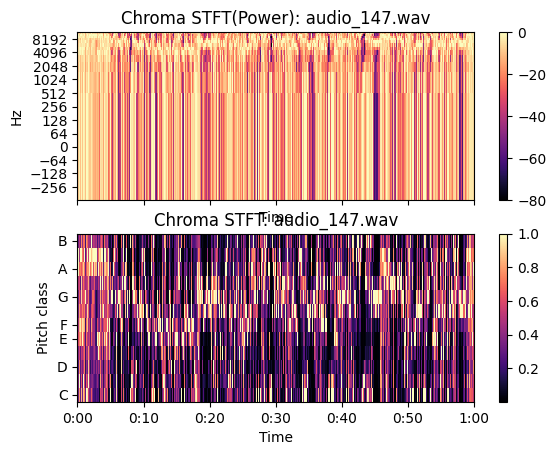

In [8]:
# visualizing cstft
chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
chroma_stft_db = librosa.amplitude_to_db(chroma_stft, ref=np.max)
print(f'Shape of Chroma STFT: {chroma_stft.shape}')

plt.figure(figsize=(12,6))
fig, ax = plt.subplots(nrows=2, sharex=True)

img = librosa.display.specshow(chroma_stft_db, x_axis='time', y_axis='log', ax=ax[0])
fig.colorbar(img, ax=ax[0])
ax[0].set(title=f'Chroma STFT(Power): {train_df.iloc[rand_sample]["filename"]}')

img = librosa.display.specshow(chroma_stft, x_axis='time', y_axis='chroma', ax=ax[1])
fig.colorbar(img, ax=ax[1])
ax[1].set(title=f'Chroma STFT: {train_df.iloc[rand_sample]["filename"]}')
# fig.tight_layout()
fig.show()

In [9]:
zcr = librosa.feature.zero_crossing_rate(y=y)
print(f'ZCR: {zcr}')
print(f'Shape of ZCR: {zcr.shape}')
spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
print(f'Spectral Centroid: {spec_centroid}')
print(f'Shape of Spectral Centroid: {spec_centroid.shape}')

ZCR: [[0.10595703 0.16210938 0.21728516 ... 0.18554688 0.14941406 0.12060547]]
Shape of ZCR: (1, 2588)
Spectral Centroid: [[3042.53129974 2985.63263685 2948.64451423 ... 2652.82142583
  2399.98271287 2349.59996446]]
Shape of Spectral Centroid: (1, 2588)


# Preprocessing - Feature Extraction

## Function to extract prosodic features
- pitch
- f0
- hnr
- jitter
- shimmer

In [10]:
def measure_prosodic_features(audio_file, f0min, f0max, unit):
    sound = parselmouth.Sound(audio_file) # read the sound
    pitch = call(sound, "To Pitch", 0.0, f0min, f0max) #create a praat pitch object
    meanF0 = call(pitch, "Get mean", 0, 0, unit) # get mean pitch
    stdevF0 = call(pitch, "Get standard deviation", 0 ,0, unit) # get standard deviation
    harmonicity = call(sound, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
    hnr = call(harmonicity, "Get mean", 0, 0)
    pointProcess = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
    localJitter = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    localabsoluteJitter = call(pointProcess, "Get jitter (local, absolute)", 0, 0, 0.0001, 0.02, 1.3)
    rapJitter = call(pointProcess, "Get jitter (rap)", 0, 0, 0.0001, 0.02, 1.3)
    ppq5Jitter = call(pointProcess, "Get jitter (ppq5)", 0, 0, 0.0001, 0.02, 1.3)
    ddpJitter = call(pointProcess, "Get jitter (ddp)", 0, 0, 0.0001, 0.02, 1.3)
    localShimmer =  call([sound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    localdbShimmer = call([sound, pointProcess], "Get shimmer (local_dB)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq3Shimmer = call([sound, pointProcess], "Get shimmer (apq3)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    aqpq5Shimmer = call([sound, pointProcess], "Get shimmer (apq5)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq11Shimmer =  call([sound, pointProcess], "Get shimmer (apq11)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    ddaShimmer = call([sound, pointProcess], "Get shimmer (dda)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    

    return list([meanF0, stdevF0, hnr, localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter, localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer])

## Function to extract acoustic features:
- mfcc
- chroma_stft
- zcr
- spec_centroid

In [11]:
def extract_acoustic_features(audio_file):
    y, sr = librosa.load(audio_file)
    features = []
    
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    features.extend(np.mean(mfcc, axis=1))
    features.extend(np.std(mfcc, axis=1))

    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    features.extend(np.mean(chroma_stft, axis=1))
    features.extend(np.std(chroma_stft, axis=1))

    zcr = librosa.feature.zero_crossing_rate(y=y)
    features.extend([np.mean(zcr), np.std(zcr)])

    spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    features.extend([np.mean(spec_centroid), np.std(spec_centroid)])

    return features

In [12]:
def run_extraction(paths_to_audios):
    # mean_F0_list = []
    # sd_F0_list = []
    # hnr_list = []
    # localJitter_list = []
    # localabsoluteJitter_list = []
    # rapJitter_list = []
    # ppq5Jitter_list = []
    # ddpJitter_list = []
    # localShimmer_list = []
    # localdbShimmer_list = []
    # apq3Shimmer_list = []
    # aqpq5Shimmer_list = []
    # apq11Shimmer_list = []
    # ddaShimmer_list = []
    features = []
    
    # Go through all the wave files in the folder and measure pitch
    for wave_file in tqdm(paths_to_audios, desc="Extracting features"):
        sound = parselmouth.Sound(wave_file)
        # (meanF0, stdevF0, hnr, localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter, localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer) = measure_prosodic_features(sound, 75, 500, "Hertz")
        feats = measure_prosodic_features(sound, 75, 500, "Hertz")
        # mean_F0_list.append(meanF0) # make a mean F0 list
        # sd_F0_list.append(stdevF0) # make a sd F0 list
        # hnr_list.append(hnr)
        # localJitter_list.append(localJitter)
        # localabsoluteJitter_list.append(localabsoluteJitter)
        # rapJitter_list.append(rapJitter)
        # ppq5Jitter_list.append(ppq5Jitter)
        # ddpJitter_list.append(ddpJitter)
        # localShimmer_list.append(localShimmer)
        # localdbShimmer_list.append(localdbShimmer)
        # apq3Shimmer_list.append(apq3Shimmer)
        # aqpq5Shimmer_list.append(aqpq5Shimmer)
        # apq11Shimmer_list.append(apq11Shimmer)
        # ddaShimmer_list.append(ddaShimmer)

        feats.extend(extract_acoustic_features(wave_file))
        features.append(feats)
        
        
        
    features = np.array(features)
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    return features

# Extract features for a selected set of random samples for better understanding

In [13]:
import random

rand_sample_paths = []
for i in range(5):
    rand_sample = random.randint(1, train_df.shape[0])
    rand_sample_path = os.path.join(train_audios_dir, train_df.iloc[rand_sample]['filename'])
    print(f'random sample index: {rand_sample}')
    rand_sample_paths.append(rand_sample_path)

rand_sample_paths

random sample index: 289
random sample index: 116
random sample index: 96
random sample index: 41
random sample index: 266


['/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/train/audio_286.wav',
 '/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/train/audio_387.wav',
 '/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/train/audio_201.wav',
 '/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/train/audio_1214.wav',
 '/kaggle/input/shl-intern-hiring-assessment/Dataset/audios/train/audio_1236.wav']

In [14]:
rand_sample_features = run_extraction(rand_sample_paths)
rand_sample_features.shape

Extracting features: 100%|██████████| 5/5 [00:07<00:00,  1.42s/it]


(5, 82)

# Extract features for entire dataset

In [15]:
audios_paths = [os.path.join(train_audios_dir, row['filename']) for idx, row in train_df.iterrows()]
len(audios_paths)

444

In [16]:
X = run_extraction(audios_paths)
y = train_df['label'].to_numpy()

print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')

Extracting features: 100%|██████████| 444/444 [11:15<00:00,  1.52s/it]

Shape of X: (444, 82)
Shape of y: (444,)


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of X_train: (355, 82)
Shape of y_train: (355,)
Shape of X_test: (89, 82)
Shape of y_test: (89,)


#### Random Forest Regressor

In [19]:
model_rgr = RandomForestRegressor(n_estimators=200, random_state=42)
model_rgr.fit(X_train, y_train)

y_pred = model_rgr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
pearson_coeff, _ = pearsonr(y_test, y_pred)
mse_train = mean_squared_error(y_train, model_rgr.predict(X_train))

print(f'MAE: {mae:.3f}')
print(f'MSE: {mse:.3f}')
print(f'MSE on training data: {mse_train:.3f}')
print(f'Pearson Correlation: {pearson_coeff:.3f}')

MAE: 0.693
MSE: 0.764
MSE on training data: 0.102
Pearson Correlation: 0.719


#### Gradient Boosting Regressor

In [21]:
model_gbr = GradientBoostingRegressor(n_estimators=500,
    max_depth=4,
    min_samples_split=7,
    learning_rate=0.1,
    loss="squared_error",
    random_state=42
)
model_gbr.fit(X_train, y_train)

y_pred = model_gbr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
pearson_coeff, _ = pearsonr(y_test, y_pred)
mse_train = mean_squared_error(y_train, model_gbr.predict(X_train))

print(f'MAE: {mae:.3f}')
print(f'MSE: {mse:.3f}')
print(f'MSE on training data: {mse_train:.3f}')
print(f'Pearson Correlation: {pearson_coeff:.3f}')

MAE: 0.632
MSE: 0.659
MSE on training data: 0.000
Pearson Correlation: 0.748


# Predict for submission dataset

In [22]:
test_df = pd.read_csv(os.path.join(dataset_root, 'test.csv'))
test_df.head()

,filename
0,audio_804.wav
1,audio_1028.wav
2,audio_865.wav
3,audio_774.wav
4,audio_1138.wav


In [23]:
filenames = [os.path.join(test_audios_dir, row['filename']) for idx, row in test_df.iterrows()]
len(filenames)

204

In [25]:
sub_features = run_extraction(filenames)
print(f'Shape of features df: {sub_features.shape}')

Extracting features: 100%|██████████| 204/204 [04:42<00:00,  1.38s/it]

Shape of features df: (204, 82)


In [26]:
y_sub_rgr = model_rgr.predict(sub_features)
y_sub_gbr = model_gbr.predict(sub_features)
print(f"Shape of y_sub_rgr: {y_sub_rgr.shape}")
print(f"Shape of y_sub_gbr: {y_sub_gbr.shape}")

Shape of y_sub_rgr: (204,)
Shape of y_sub_gbr: (204,)


In [27]:
sub_filenames = test_df['filename'].to_list()

temp_dict_rgr = {
    'filename': sub_filenames,
    'label': y_sub_rgr
}
temp_dict_gbr = {
    'filename': sub_filenames,
    'label': y_sub_gbr
}
df_sub_rgr = pd.DataFrame(temp_dict_rgr)
df_sub_gbr = pd.DataFrame(temp_dict_gbr)

In [28]:
df_sub_rgr.to_csv('submission1.csv', index=False)
df_sub_gbr.to_csv('submission2.csv', index=False)

In [29]:
df_sub_gbr.describe()

,label
count,204.000000
mean,3.811379
std,0.603920
min,2.363772
25%,3.352906
50%,3.779901
75%,4.320965
max,5.248480


In [31]:
df_sub_rgr.describe()

,label
count,204.000000
mean,3.850074
std,0.504092
min,2.717500
25%,3.470625
50%,3.826250
75%,4.218125
max,4.782500


In [33]:
sub_prev = pd.read_csv('/kaggle/input/submission-csv/submission (2).csv')
sub_prev.describe()

,label
count,195.000000
mean,3.630274
std,0.492700
min,2.486667
25%,3.300000
50%,3.646667
75%,3.946667
max,4.806667
